<a href="https://colab.research.google.com/github/nicholasjbeaver/Computational-Materials-Science-Projects/blob/main/Monte_Carlo_Structure_Generation.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Monte Carlo Sampling of SPHEA Configuration Space

## Installation

In [1]:
!pip install -q dgl==1.0.1+cu117 -f https://data.dgl.ai/wheels/cu117/repo.html
!pip install -q alignn==2024.1.14

!pip install -q ase
!pip install -q pymatgen

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 266.3/266.3 MB 4.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 130.2/130.2 kB 4.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4.2/4.2 MB 47.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 619.9/619.9 MB 2.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 515.3/515.3 kB 49.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 305.5/305.5 kB 39.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 125.3/125.3 kB 20.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 57.6/57.6 kB 9.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 67.8/67.8 kB 10.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.9/2.9 MB 100.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 309.4/309.4 kB 40.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 62.7/62.7 kB 9.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━

In [2]:
from jarvis.core.atoms import ase_to_atoms
from jarvis.core.atoms import Atoms as JarvisAtoms
from ase.io import write
from ase.visualize import view
from ase.io import read as ASEread
from ase import Atoms
from ase.spacegroup import crystal
import numpy as np
import math
import random
from scipy.stats import norm
import matplotlib.pyplot as plt
from scipy.stats import ttest_ind
from scipy.stats import ttest_1samp
from scipy.stats import ttest_rel
import copy
import multiprocessing
import tqdm
import time
from pymatgen.core.composition import Composition
import pandas as pd
import ast
import re
import statistics

from scipy.stats import norm
import matplotlib.pyplot as plt
from scipy.stats import ttest_ind
from scipy.stats import ttest_1samp
from scipy.stats import ttest_rel

%matplotlib inline

In [3]:
from alignn.ff.ff import AlignnAtomwiseCalculator,wt10_path, ForceField, alignnff_fmult #, get_figshare_model_ff, default_path
model_path = wt10_path()
calc = AlignnAtomwiseCalculator(path=model_path)

'''
!pip install -q matgl

import matgl
from matgl.ext.ase import PESCalculator

pot = matgl.load_model("M3GNet-MP-2021.2.8-PES")
# define the M3GNet calculator
# calc = PESCalculator(pot)
'''

DGL backend not selected or invalid.  Assuming PyTorch for now.


Setting the default backend to "pytorch". You can change it in the ~/.dgl/config.json file or export the DGLBACKEND environment variable.  Valid options are: pytorch, mxnet, tensorflow (all lowercase)
dir_path /usr/local/lib/python3.10/dist-packages/alignn/ff/alignnff_fmult


100%|██████████| 118/118 [00:00<00:00, 188kiB/s]


BadZipFile: File is not a zip file

In [ ]:
def get_species(total_atoms, element_mol_fraction):
  '''
  In: total_atoms - number of atoms in supercell
      element_mol_fraction - dict of elements and fractions

  Out: list of elements of len(total_atoms) and compositon of mol fraction

  '''

  element_atom_count = {element: math.floor(total_atoms * fraction) for element, fraction in element_mol_fraction.items()}

  # Calculate the current total and determine how many atoms are missing
  current_total = sum(element_atom_count.values())
  atoms_to_add = total_atoms - current_total

  # Distribute the remaining atoms
  for element in sorted(element_mol_fraction, key=lambda e: element_mol_fraction[e], reverse=True):
      if atoms_to_add <= 0:
          break
      element_atom_count[element] += 1
      atoms_to_add -= 1

  #print(element_atom_count)

  species = []

  for element, number in element_atom_count.items():
    species.extend([element]*number)

  return(species)


def get_dummy_lattice(xtal, lattice_parameter, supercell):
  '''
  xtal = str
  lattice = float
  supercell = tuple
  '''

  spacegroup = 225

  if xtal == 'FCC':
    spacegroup = 225
  else:
    spacegroup = 229


  dummy = crystal(('Fe'),
    basis=[(0,0,0)],
    spacegroup=spacegroup, cellpar=[lattice_parameter, lattice_parameter, lattice_parameter, 90, 90, 90],
    size=supercell)

  num_atoms = len(dummy.get_chemical_symbols())

  return dummy, num_atoms

def get_initial_structure(mol_fractions, xtal, lattice_parameter, supercell):

  initial, num_atoms = get_dummy_lattice(xtal, lattice_parameter, supercell)
  species = get_species(num_atoms, mol_fractions)
  initial.set_chemical_symbols(species)
  return initial, species


def twoway_ttest(data1,data2):
  # Perform two-tailed t-test
  t_statistic, p_value = ttest_ind(data1, data2)

  # Print the results
  print("T-statistic:", t_statistic)
  print("P-value:", p_value)

  # Interpret the results
  alpha = 0.05  # significance level
  if p_value < alpha:
      print("Reject null hypothesis: There is a significant difference between the means of the two groups.")
  else:
      print("Fail to reject null hypothesis: There is no significant difference between the means of the two groups.")

  return t_statistic, p_value


def distribution(energies, label, color):
  # function for plotting histogram and normal distribution for a given list

  mean = np.mean(energies)
  std = np.std(energies)
  plt.hist(energies, bins=10, density=True, alpha=0.2, color=color, label=label)
  xmin, xmax = plt.xlim()
  x = np.linspace(xmin, xmax, 100)
  p = norm.pdf(x, mean, std)
  plt.plot(x, p, linestyle='-', color=color ,linewidth=2)

def plot_EV_dict(dictionary,label,color):
    # Extract keys and values from dictionary
    y_values = list(dictionary.keys())
    x_values = list(dictionary.values())

    # Plot the data
    plt.plot(x_values, y_values, marker='o',label=label,color=color)  # You can customize the marker style as needed

def remove_decimals(string):
     return re.sub(r'\.(\d+)', r'\1', string)

In [ ]:
def EV_data(alloy, parameter_list, xtal, supercell):
  '''
  make ev data dictionary and find lowest energy lattice parameter

  in:
  alloy (str)
  parameter_list:list
  xtal (str)
  supercell (3-tuple)

  out:
  param_energies: dict
  lowest_energy: float
  '''

  # composition object pymatgen to get mol dict
  comp = Composition(alloy)
  mols = comp.fractional_composition.as_dict()

  # get initial structure and list of elements to insert
  atoms, species = get_initial_structure(mols, xtal, 4, supercell)
  random.shuffle(species)

  # total number of atoms = length of species list
  num_atoms=len(species)

  # initialize variables
  param_energies = {}
  lowest_energy = float('inf')

  # loop through given list of lattice parameters
  for a in parameter_list:

    # make initial structure using previous function (supercell convinience)
    atoms, unused_species = get_initial_structure(mols, xtal, a, supercell)

    # setting chemical symbols the SAME way every time means only lattice parameter changes
    atoms.set_chemical_symbols(species)

    # set calculator each time since making new atoms
    atoms.calc = calc

    # use ASE calculator to get potential energy of lattice and use num_atoms to get energy/atom
    energy = atoms.get_potential_energy()
    energy_per_atom = energy/num_atoms

    # put entry in dictionary, key on energy for lowest_energy lookup later
    param_energies[energy_per_atom]=a

    # compare to lowest
    if energy_per_atom<lowest_energy:
      lowest_energy = energy_per_atom

  return param_energies, lowest_energy




In [ ]:
def relax_lattice(ase_atoms,steps=100,fmax=0.1, logfile_name ="opt.log"):
    '''
    Optimizes the lattice structure of a POSCAR file using the specified alignn-ff model

    Inputs:
      ase_atoms: ase_atoms

    Returns:
      opt: optimized lattice structure (jarvis.core.atoms.Atoms object)

    '''

    jarvis_atoms=ase_to_atoms(ase_atoms)

    # run alignn-ff on the specified atom system and predict a forcefield

    ff = ForceField(
        jarvis_atoms=jarvis_atoms,
        model_path=model_path,
        stress_wt=0.3,
        force_multiplier=1,
        force_mult_natoms=False,
    )

    # optimize lattice structure by minimizing energy

    opt, en, fs = ff.optimize_atoms(steps=steps,fmax=fmax, logfile = logfile_name)

    # convert to ase and get energy per atom
    ase = opt.ase_converter()
    num_atoms = len(ase.get_chemical_symbols())
    energy_per_atom = en/num_atoms

    return ase, energy_per_atom

In [ ]:
def random_structure_search(alloy, xtal, lattice, supercell, num_structures):
  '''
  single function to randomly sample configuration space

  in:
  alloy (str)
  xtal (str)
  lattice (float) - parameter
  supercell (3-tuple)
  num_strucutres (int)

  out:
  winner: ASE atoms (lowest energy structure)
  energies (list)
  lowest_energy (float)
  '''


  # use composition object to turn alloy name into dictionary
  comp = Composition(alloy)
  mols = comp.fractional_composition.as_dict()

  # get initial atoms structure and add ASE calculator (ALIGNN-ff)
  # specify cubic spacegroup and supercell dimensions
  atoms, species = get_initial_structure(mols, xtal, lattice, supercell)
  atoms.set_chemical_symbols(species)

  # length of species list = number of atoms
  num_atoms = len(species)

  # global definition
  energies = []
  lowest_energy = float('inf')
  winner = None

  # loop through iterations
  for i in tqdm.tqdm(range(num_structures), desc=f'Processing {xtal} {alloy}', unit='iteration'):

    # shuffle atom positons
    random.shuffle(species)
    atoms.set_chemical_symbols(species)


    # calculate energy and get energy per atom
    atoms.calc = calc
    energy = atoms.get_potential_energy()
    energy_per_atom = energy/num_atoms
    energies.append(energy_per_atom)

    # compare to lowest
    if energy_per_atom<lowest_energy:

      winner = copy.deepcopy(atoms)
      lowest_energy = copy.deepcopy(energy_per_atom)


  return winner, energies


In [ ]:
def RSS_all(alloy, xtal, lattice, supercell, num_structures):
  '''
  single function to randomly sample configuration space

  in:
  alloy (str)
  xtal (str)
  lattice (float) - parameter
  supercell (3-tuple)
  num_strucutres (int)

  out:
  energies - dict of energy:ASE atoms
  '''


  # use composition object to turn alloy name into dictionary
  comp = Composition(alloy)
  mols = comp.fractional_composition.as_dict()

  # get initial atoms structure and add ASE calculator (ALIGNN-ff)
  # specify cubic spacegroup and supercell dimensions
  atoms, species = get_initial_structure(mols, xtal, lattice, supercell)
  atoms.set_chemical_symbols(species)

  # length of species list = number of atoms
  num_atoms = len(species)

  # global definition
  energies = {}

  # loop through iterations
  for i in tqdm.tqdm(range(num_structures), desc=f'Processing {xtal} {alloy}', unit='iteration'):

    # shuffle atom positons
    random.shuffle(species)
    atoms.set_chemical_symbols(species)


    # calculate energy and get energy per atom
    atoms.calc = calc
    energy = atoms.get_potential_energy()
    energy_per_atom = energy/num_atoms

    energies[energy_per_atom]= atoms


  return energies

In [ ]:
alloy = 'CoCrFeNi'
supercell = (3,3,3)
num_structures = 10

d = RSS_all(alloy, 'FCC', 3.54, supercell, num_structures)

low = min(d.keys())
high = max(d.keys())

med= statistics.mean(d.keys())
mean_key = min(d, key=lambda x: abs(x - med))


LS = d[low]
HS = d[high]
MS = d[mean_key]

In [ ]:
print(low)
view(LS, viewer='x3d')

In [ ]:
print(mean_key)
view(MS, viewer='x3d')

In [ ]:
print(high)
view(HS, viewer='x3d')

## Function Tests

In [ ]:
alloy = 'CoCrFeNi'
supercell = (3,3,3)
num_structures = 500
alloy_string = remove_decimals(alloy)


# use avg lattice parameters to do the random structure search for FCC and BCC
FCCwinner, FCCenergies = random_structure_search(alloy, 'FCC', 3.54, supercell, num_structures)
BCCwinner, BCCenergies = random_structure_search(alloy, 'BCC', 3, supercell, num_structures)

# use for prediction pre relax
FCCmin = min(FCCenergies)
BCCmin = min(BCCenergies)

'''
# relax the winning structures and find the energy
FCCrelaxed, FCC_ground_energy = relax_lattice(FCCwinner,logfile_name=f'{alloy_string}_FCC.log')
BCCrelaxed, BCC_ground_energy = relax_lattice(BCCwinner,logfile_name=f'{alloy_string}_BCC.log')
'''


# make row dictionary for concat
row_dict = {'alloy':alloy, 'FCClowest_before_relaxation': FCCmin, 'BCClowest_before_relaxation':BCCmin,
            'FCClowest':FCC_ground_energy, 'BCClowest':BCC_ground_energy, 'FCCenergies':FCCenergies,
            'BCCenergies':BCCenergies, 'FCC parameter': FCCa, 'BCC parameter':BCCa,
            'FCC ev1': FCC1, 'BCC ev1':BCC1}




Processing FCC CoCrFeNi:   0%|          | 0/500 [00:00<?, ?iteration/s]/usr/local/lib/python3.10/dist-packages/dgl/backend/pytorch/tensor.py:445: UserWarning: TypedStorage is deprecated. It will be removed in the future and UntypedStorage will be the only storage class. This should only matter to you if you are using storages directly.  To access UntypedStorage directly, use tensor.untyped_storage() instead of tensor.storage()
  assert input.numel() == input.storage().size(), (
Processing FCC CoCrFeNi:   5%|▍         | 23/500 [00:06<02:10,  3.67iteration/s]


KeyboardInterrupt: 

In [ ]:
%matplotlib inline

plot_EV_dict(FCC1,'FCC','g')
plot_EV_dict(BCC1,'BCC','b')



plt.xlabel('lattice parameter')
plt.ylabel('energy per atom')
plt.title(f'EV curve for {alloy}')
plt.legend()
plt.grid(True)
plt.show()


In [35]:
alloy = 'CoCrFeNi'
supercell = (3,3,3)
num_structures = 100

FCC = RSS_all(alloy, 'FCC', 3.54, supercell, num_structures)

FCCenergies=list(FCC.keys())
Flow = min(FCC.keys())
Fhigh = max(FCC.keys())
Fmean= statistics.mean(FCC.keys())
Fmed = min(FCC, key=lambda x: abs(x - med))

BCC = RSS_all(alloy, 'FCC', 3.54, supercell, num_structures)

BCCenergies=list(BCC.keys())
Blow = min(BCC.keys())
Bhigh = max(BCC.keys())
Bmean= statistics.mean(BCC.keys())
Bmed = min(BCC, key=lambda x: abs(x - med))

'''
FLS = FCC[low]
FHS = FCC[high]
FMS = FCC[mean_key]
'''

Processing FCC CoCrFeNi:   0%|          | 0/100 [00:00<?, ?iteration/s]/usr/local/lib/python3.10/dist-packages/dgl/backend/pytorch/tensor.py:445: UserWarning: TypedStorage is deprecated. It will be removed in the future and UntypedStorage will be the only storage class. This should only matter to you if you are using storages directly.  To access UntypedStorage directly, use tensor.untyped_storage() instead of tensor.storage()
  
Processing FCC CoCrFeNi: 100%|██████████| 100/100 [00:24<00:00,  4.00iteration/s]


'\nFLS = FCC[low]\nFHS = FCC[high]\nFMS = FCC[mean_key]\n'

T-statistic: 0.8419903611576985
P-value: 0.40080918265042287
Fail to reject null hypothesis: There is no significant difference between the means of the two groups.


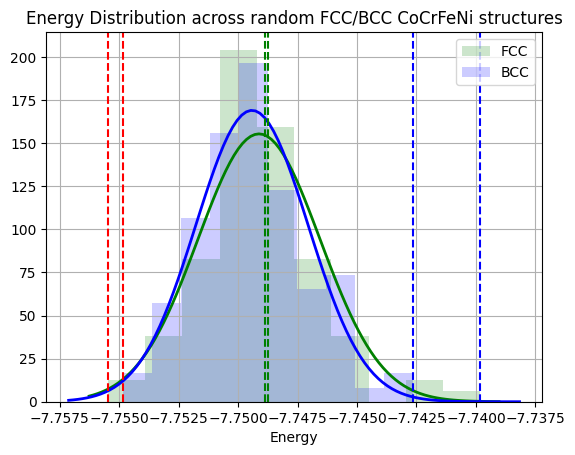

In [36]:
distribution(FCCenergies, 'FCC', 'g')
distribution(BCCenergies, 'BCC', 'b')

plt.axvline(x=Flow, color='r', linestyle='--')
plt.axvline(x=Fmed, color='g', linestyle='--')
plt.axvline(x=Fhigh, color='b', linestyle='--')
plt.axvline(x=Blow, color='r', linestyle='--')
plt.axvline(x=Bmed, color='g', linestyle='--')
plt.axvline(x=Bhigh, color='b', linestyle='--')

# get statistics
t_stat, p_val = twoway_ttest(FCCenergies, BCCenergies)


plt.title(f'Energy Distribution across random FCC/BCC {alloy} structures')
plt.xlabel('Energy')
plt.grid(True)
plt.legend()
plt.show()

In [ ]:
print(row_dict['FCClowest_before_relaxation'])
print(row_dict['BCClowest_before_relaxation'])

In [ ]:
# relax the winning structures and find the energy
FCCrelaxed, FCC_ground_energy = relax_lattice(FCCwinner, fmax = 0.05, logfile_name=f'{alloy_string}_FCC.log')
BCCrelaxed, BCC_ground_energy = relax_lattice(BCCwinner, fmax = 0.05, logfile_name=f'{alloy_string}_BCC.log')
print(FCC_ground_energy, BCC_ground_energy)

In [ ]:
# relax the winning structures and find the energy
FCCrelaxed, FCC_ground_2 = relax_lattice(FCCwinner, fmax = 0.05, logfile_name=f'{alloy_string}_FCC2.log')
BCCrelaxed, BCC_ground_2 = relax_lattice(BCCwinner, fmax = 0.05, logfile_name=f'{alloy_string}_BCC2.log')
print(FCC_ground_2, BCC_ground_2)

In [ ]:
print(FCC_ground_energy, BCC_ground_energy)

In [ ]:
view('FCCwinner', viewer='x3d')

## Test on experimental dataset


In [37]:
from google.colab import drive
drive.mount('/content/drive')
criteria = pd.read_csv('/content/drive/MyDrive/Senior Project - ML prediction of HEAs/FINAL datasets/phase_criteria.csv')
criteria = criteria[~criteria['Experimental'].isna()]

Mounted at /content/drive


In [40]:
alloys = list(criteria['alloy'])
print(len(alloys))
print(alloys)

132
['Al0.25MoNbTiV', 'Al2CoCrFeMo0.5Ni', 'CoCrMnNi', 'Al2.5CoCrFeNi', 'Al0.3CoCrCuFeNi', 'AlCoCrFeNb0.1Ni', 'Al0.25CoCrCu0.75FeNiTi0.5', 'CoCrFeNiTi', 'Al2.8CoCrCuFe', 'AlCoFeNi', 'Al0.5CrFe1.5MnNi0.5', 'NbTiV0.3Mo0.7', 'AlCrFeNi', 'CoFeNiV', 'CoCuFeMnNi', 'NbTiV0.3Mo1.3', 'CrCuFeMoNi', 'CoCrFeMnNiV0.25', 'HfMo0.25NbTaTiZr', 'CoCrFeMnNiV0.5', 'NbTiV0.3Mo0.5', 'NbTiV0.3Zr', 'MoNbTiV0.25Zr', 'CoCrCu0.5FeNi', 'FeMnNi', 'Al3CoCrCuFeNi', 'CoCrCuFeNiTi', 'MoNbTaW', 'MoNbTiZr', 'Al1.25CoCrFeMnNi', 'Al0.75HfNbTaTiZr', 'Al0.25CoFeNi', 'AlCrFeNiMo0.2', 'Mo0.5NbTiVZr', 'CoMnNi', 'AlCoFeNiTiVZr', 'CoCrCuFe', 'AlMo0.5NbTa0.5TiZr', 'CoCrNi', 'Co1.5CrFeNi1.5Ti0.5', 'MoNbTiV1.5Zr', 'NbTaTiV', 'Al0.25NbTaTiV', 'Al0.875CoCrFeNi', 'Al0.2Co1.5CrFeNi1.5Ti0.5', 'Al0.5CoCrCuFeNiV1.6', 'MoNbTaV', 'HfNbTiZr', 'Al0.3HfNbTaTiZr', 'AlCoCrCuNiTi', 'CoCuFeNiSn0.02', 'Al0.5CoCrCuFeNiTi0.4', 'NbTiV0.3Mo1.5', 'AlCrFeNiMo0.5', 'Al0.5CoCrCuFeNiTi0.2', 'Al0.25CoCrCu0.5FeNiTi0.5', 'Al0.8CoCrCuFeNi', 'Mo1.3NbTiVZr', 'HfMo

### Original

In [41]:
columns = ['alloy', 'FCClowest_before_relaxation', 'BCClowest_before_relaxation',
           'FCClowest', 'BCClowest', 'FCCenergies','BCCenergies',
           'FCC parameter','BCC parameter',
           'FCC logfile', 'BCC logfile']

monte = pd.DataFrame(columns=columns)
monte.head()

,alloy,FCClowest_before_relaxation,BCClowest_before_relaxation,FCClowest,BCClowest,FCCenergies,BCCenergies,FCC parameter,BCC parameter,FCC logfile,BCC logfile


In [43]:
supercell = (3,3,3)
num_structures = 500
bad_alloys = []
struct_dir = '/content/drive/MyDrive/Senior Project - ML prediction of HEAs/Random Structures'
relaxed_dir = '/content/drive/MyDrive/Senior Project - ML prediction of HEAs/Random Structures'

for alloy in alloys:
  try:

    # get alloy string for file names
    alloy_string = remove_decimals(alloy)

    # use avg lattice parameters to do the random structure search for FCC and BCC
    FCCwinner, FCCenergies = random_structure_search(alloy, 'FCC', 3.54, supercell, num_structures)
    BCCwinner, BCCenergies = random_structure_search(alloy, 'BCC', 3, supercell, num_structures)

    # use for prediction pre relax
    FCCmin = min(FCCenergies)
    BCCmin = min(BCCenergies)

    # relax the winning structures and find the energy
    FCCrelaxed, FCC_ground_energy = relax_lattice(FCCwinner,logfile_name=f'{alloy_string}_FCC.log')
    BCCrelaxed, BCC_ground_energy = relax_lattice(BCCwinner,logfile_name=f'{alloy_string}_BCC.log')


    '''
    # save relaxed poscar files to drive
    write(f'{relaxed_dir}/relaxed_{alloy_string}_FCC.vasp', FCCrelaxed, format='vasp')
    write(f'{relaxed_dir}/relaxed_{alloy_string}_BCC.vasp', BCCrelaxed, format='vasp')

    # save unrelaxed poscar files to drive
    write(f'{struct_dir}/{alloy_string}_FCC.vasp', FCCwinner, format='vasp')
    write(f'{struct_dir}/{alloy_string}_BCC.vasp', BCCwinner, format='vasp')
    '''

    # get logfile data to put in the row

    with open (f'{alloy_string}_FCC.log','r') as f:
        FCClog = f.readlines()

    with open (f'{alloy_string}_BCC.log','r') as f:
        BCClog = f.readlines()


    # make row dictionary for concat
    row_dict = {'alloy':alloy, 'FCClowest_before_relaxation': FCCmin, 'BCClowest_before_relaxation':BCCmin,
            'FCClowest':FCC_ground_energy, 'BCClowest':BCC_ground_energy, 'FCCenergies':FCCenergies,
            'BCCenergies':BCCenergies,'FCC logfile':FCClog, 'BCC logfile':BCClog}

    row = pd.DataFrame([row_dict], index=[None])
    monte = pd.concat([monte,row], ignore_index=True)

  except:
    bad_alloys.append(alloy)


print(bad_alloys)

['Al0.25MoNbTiV', 'Al2CoCrFeMo0.5Ni', 'CoCrMnNi', 'Al2.5CoCrFeNi', 'Al0.3CoCrCuFeNi', 'AlCoCrFeNb0.1Ni', 'Al0.25CoCrCu0.75FeNiTi0.5', 'CoCrFeNiTi', 'Al2.8CoCrCuFe', 'AlCoFeNi', 'Al0.5CrFe1.5MnNi0.5', 'NbTiV0.3Mo0.7', 'AlCrFeNi', 'CoFeNiV', 'CoCuFeMnNi', 'NbTiV0.3Mo1.3', 'CrCuFeMoNi', 'CoCrFeMnNiV0.25', 'HfMo0.25NbTaTiZr', 'CoCrFeMnNiV0.5', 'NbTiV0.3Mo0.5', 'NbTiV0.3Zr', 'MoNbTiV0.25Zr', 'CoCrCu0.5FeNi', 'FeMnNi', 'Al3CoCrCuFeNi', 'CoCrCuFeNiTi', 'MoNbTaW', 'MoNbTiZr', 'Al1.25CoCrFeMnNi', 'Al0.75HfNbTaTiZr', 'Al0.25CoFeNi', 'AlCrFeNiMo0.2', 'Mo0.5NbTiVZr', 'CoMnNi', 'AlCoFeNiTiVZr', 'CoCrCuFe', 'AlMo0.5NbTa0.5TiZr', 'CoCrNi', 'Co1.5CrFeNi1.5Ti0.5', 'MoNbTiV1.5Zr', 'NbTaTiV', 'Al0.25NbTaTiV', 'Al0.875CoCrFeNi', 'Al0.2Co1.5CrFeNi1.5Ti0.5', 'Al0.5CoCrCuFeNiV1.6', 'MoNbTaV', 'HfNbTiZr', 'Al0.3HfNbTaTiZr', 'AlCoCrCuNiTi', 'CoCuFeNiSn0.02', 'Al0.5CoCrCuFeNiTi0.4', 'NbTiV0.3Mo1.5', 'AlCrFeNiMo0.5', 'Al0.5CoCrCuFeNiTi0.2', 'Al0.25CoCrCu0.5FeNiTi0.5', 'Al0.8CoCrCuFeNi', 'Mo1.3NbTiVZr', 'HfMoTaTi

In [ ]:
monte['prediction']= monte.apply((lambda x: 'FCC' if x['FCClowest']< x['BCClowest'] else 'BCC'), axis=1)
monte['before_relax_prediction']= monte.apply((lambda x: 'FCC' if x['FCClowest_before_relaxation']< x['BCClowest_before_relaxation'] else 'BCC'), axis=1)

In [ ]:
resultdf = pd.merge(monte, criteria, on='alloy')
#resultdf.to_csv('/content/drive/MyDrive/Senior Project - ML prediction of HEAs/Random Structures/senior_exp_alloys.csv')


In [ ]:
resultdf[resultdf['prediction'] == resultdf['Experimental']].shape[0]/132

In [ ]:
resultdf[resultdf['before_relax_prediction'] == resultdf['Experimental']].shape[0]/132

In [ ]:
resultdf.to_csv('montebackup.csv')

### New

In [52]:
supercell = (3,3,3)
num_structures = 5
bad_alloys = []
struct_dir = '/content/drive/MyDrive/Senior Project - ML prediction of HEAs/Random Structures'
relaxed_dir = '/content/drive/MyDrive/Senior Project - ML prediction of HEAs/Random Structures'

pred = {}

for alloy in alloys:
  try:

    FCC = RSS_all(alloy, 'FCC', 3.54, supercell, num_structures)

    FCCenergies=list(FCC.keys())
    Flow = min(FCC.keys())
    Fhigh = max(FCC.keys())
    Fmean= statistics.mean(FCC.keys())
    Fmed = min(FCC, key=lambda x: abs(x - med))

    BCC = RSS_all(alloy, 'FCC', 3.54, supercell, num_structures)

    BCCenergies=list(BCC.keys())
    Blow = min(BCC.keys())
    Bhigh = max(BCC.keys())
    Bmean= statistics.mean(BCC.keys())
    Bmed = min(BCC, key=lambda x: abs(x - med))

    res = 'FCC' if Flow < Blow else 'BCC'

    pred[alloy] = res

  except:
    bad_alloys.append(alloy)

resultdf = pd.DataFrame([pred]).T
resultdf.columns = ['prediction']

print(bad_alloys)

Processing FCC Al0.25MoNbTiV:   0%|          | 0/5 [00:00<?, ?iteration/s]/usr/local/lib/python3.10/dist-packages/dgl/backend/pytorch/tensor.py:445: UserWarning: TypedStorage is deprecated. It will be removed in the future and UntypedStorage will be the only storage class. This should only matter to you if you are using storages directly.  To access UntypedStorage directly, use tensor.untyped_storage() instead of tensor.storage()
  
Processing FCC CoCuFeMnNiSn0.03: 100%|██████████| 5/5 [00:01<00:00,  4.04iteration/s]

[]


In [53]:
resultdf = pd.merge(resultdf, criteria, right_on='alloy', left_index=True)
resultdf.head()

,prediction,alloy,Experimental,GNN,LSS1,LSS2,LSS3,LSS4,LSS5
0,BCC,Al0.25MoNbTiV,BCC,BCC,BCC,Uncertain,Uncertain,BCC,Uncertain
1,FCC,Al2CoCrFeMo0.5Ni,BCC,BCC,BCC,BCC,Uncertain,Uncertain,Uncertain
2,BCC,CoCrMnNi,FCC,FCC,FCC,FCC,Uncertain,FCC,Uncertain
3,FCC,Al2.5CoCrFeNi,BCC,BCC,BCC,BCC,Uncertain,Uncertain,Uncertain
4,BCC,Al0.3CoCrCuFeNi,FCC,FCC,FCC,FCC,Uncertain,FCC,Uncertain


In [54]:
resultdf[resultdf['prediction'] == resultdf['Experimental']].shape[0]/132


0.4166666666666667

## Analysis

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import math
import random
from scipy.stats import norm
import matplotlib.pyplot as plt
from scipy.stats import ttest_ind
from scipy.stats import ttest_1samp
from scipy.stats import ttest_rel

from google.colab import drive
drive.mount('/content/drive')
criteria = pd.read_csv('/content/drive/MyDrive/Senior Project - ML prediction of HEAs/FINAL datasets/phase_criteria.csv')
criteria = criteria[~criteria['Experimental'].isna()]

In [ ]:
total=pd.read_csv('/content/drive/MyDrive/Senior Project - ML prediction of HEAs/Random Structures/batch_3.csv')
total.info()

In [ ]:
monteright = total['prediction'] == total['Experimental']
before_relax = total['before_relax_prediction'] == total['Experimental']
GNNright =  total['GNN']== total['Experimental']
LSS1right = total['LSS1 ']== total['Experimental']

In [ ]:
total[monteright].shape[0]

In [ ]:
total[before_relax].shape[0]

In [ ]:
total['energy difference'] = total['FCClowest']-total['BCClowest']
total['energy difference'].mean()

In [ ]:
old=pd.read_csv('/content/drive/MyDrive/Senior Project - ML prediction of HEAs/Random Structures/monte_and_relaxation.csv')

In [ ]:
def result_from_list(row):

  FCCenergies = eval(row['FCCenergies'])
  BCCenergies = eval(row['BCCenergies'])

  FCC = min(FCCenergies)
  BCC = min(BCCenergies)

  result = 'FCC' if FCC < BCC else 'BCC'

  return result

old['before_relax'] = old.apply(result_from_list, axis=1)

In [ ]:
old['before_relax'].head()

In [ ]:
unrelaxed_correct = old['before_relax']== old['Experimental']
old[unrelaxed_correct].shape[0]

In [ ]:
old[old['Experimental'] != old['before_relax']].head(2)

In [ ]:
old[~unrelaxed_correct]['Experimental'].value_counts()

In [ ]:
old['Experimental'].value_counts()

In [ ]:
exp = old['Experimental'].value_counts()
brel = old['before_relax'].value_counts()

print(exp, brel)

In [ ]:
diff = pd.merge(total[['alloy', 'Experimental','before_relax_prediction']], old[['alloy','before_relax']], on='alloy')

In [ ]:
oldright = diff['before_relax'] == diff['Experimental']
newright = diff['before_relax_prediction'] == diff['Experimental']
different = diff['before_relax_prediction'] != diff['before_relax']

In [ ]:
diff[oldright & different].head()

In [ ]:
total[(~newright) &(total['FCC parameter']>4)].head()

In [ ]:
alloy = 'MoNbTaVW'


oldFCC = eval(old.loc[old['alloy'] == alloy, 'FCCenergies'].iloc[0])
oldBCC = eval(old.loc[old['alloy'] == alloy, 'BCCenergies'].iloc[0])

newFCC = eval(total.loc[total['alloy'] == alloy, 'FCCenergies'].iloc[0])
newBCC = eval(total.loc[total['alloy'] == alloy, 'BCCenergies'].iloc[0])


distribution(oldFCC, 'old FCC', 'g')
distribution(oldBCC, 'old BCC', 'b')


distribution(newFCC, ' new FCC', 'r')
distribution(newBCC, 'new BCC', 'y')


Fa = total[total['alloy']==alloy]['FCC parameter'].iloc[0]
Ba = total[total['alloy']==alloy]['BCC parameter'].iloc[0]

print('Actual structure')
print(total[total['alloy']==alloy]['Experimental'].iloc[0])
print('-----------------')
print('lattice parameters')
print(f'FCC: 3.54, {Fa}')
print(f'BCC: 3, {Ba}')
print('-----------------------------')
print('min energies - old, new')
print(f'FCC: {min(oldFCC)}, {min(newFCC)}')
print(f'BCC: {min(oldBCC)}, {min(newBCC)}')

# get statistics
# t_stat, p_val = twoway_ttest(oldBCC, oldFCC)


%matplotlib inline

plt.title(f'Energy Distribution across random FCC/BCC {alloy} structures')
plt.xlabel('Energy')
plt.grid(True)
plt.legend()
plt.show()

In [ ]:
FCC1 = eval(total.loc[total['alloy'] == alloy, 'FCC ev1'].iloc[0])
FCC2 = eval(total.loc[total['alloy'] == alloy, 'FCC ev2'].iloc[0])
FCC3 = eval(total.loc[total['alloy'] == alloy, 'FCC ev3'].iloc[0])
FCC4 = eval(total.loc[total['alloy'] == alloy, 'FCC ev4'].iloc[0])
FCC5 = eval(total.loc[total['alloy'] == alloy, 'FCC ev5'].iloc[0])


BCC1 = eval(total.loc[total['alloy'] == alloy, 'BCC ev1'].iloc[0])
BCC2 = eval(total.loc[total['alloy'] == alloy, 'BCC ev2'].iloc[0])
BCC3 = eval(total.loc[total['alloy'] == alloy, 'BCC ev3'].iloc[0])
BCC4 = eval(total.loc[total['alloy'] == alloy, 'BCC ev4'].iloc[0])
BCC5 = eval(total.loc[total['alloy'] == alloy, 'BCC ev5'].iloc[0])


%matplotlib inline

plot_EV_dict(FCC1,'FCC','g')
plot_EV_dict(FCC2,'FCC','g')
plot_EV_dict(FCC3,'FCC','g')
plot_EV_dict(FCC4,'FCC','g')
plot_EV_dict(FCC5,'FCC','g')


plot_EV_dict(BCC1,'BCC','b')
plot_EV_dict(BCC2,'BCC','b')
plot_EV_dict(BCC3,'BCC','b')
plot_EV_dict(BCC4,'BCC','b')
plot_EV_dict(BCC5,'BCC','b')


plt.xlabel('lattice parameter')
plt.ylabel('energy per atom')
plt.title(f'EV curve for {alloy}')
plt.legend()
plt.grid(True)
plt.show()


In [ ]:
print(total['FCC parameter'].mean())
print(total['BCC parameter'].mean())

In [ ]:
print(FCC1[min(list(FCC1.keys()))],FCC2[min(list(FCC2.keys()))],FCC3[min(list(FCC3.keys()))],FCC4[min(list(FCC4.keys()))],FCC5[min(list(FCC5.keys()))])

print(BCC1[min(list(BCC1.keys()))],BCC2[min(list(BCC2.keys()))],BCC3[min(list(BCC3.keys()))],BCC4[min(list(BCC4.keys()))],BCC5[min(list(BCC5.keys()))])

## Combined Dataset Analysis


### Dataset Setup

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import math
import random
from scipy.stats import norm
import matplotlib.pyplot as plt
from scipy.stats import ttest_ind
from scipy.stats import ttest_1samp
from scipy.stats import ttest_rel

from google.colab import drive
drive.mount('/content/drive')


In [ ]:
'''
the three batches of data - B1-3:

B1: EV curve (1x25) then permute (100) only
B2: permute (500) then relax only
B3: EV (5x50), permute (500), relax
'''

B1 = pd.read_csv('/content/drive/MyDrive/Senior Project - ML prediction of HEAs/Random Structures/montemethod132sphea.csv')
B1['prediction']= B1.apply((lambda x: 'FCC' if x['FCClowest']< x['BCClowest'] else 'BCC'), axis=1)
B1.info()

In [ ]:
def result_from_list(row):

  FCCenergies = eval(row['FCCenergies'])
  BCCenergies = eval(row['BCCenergies'])

  FCC = min(FCCenergies)
  BCC = min(BCCenergies)

  result = 'FCC' if FCC < BCC else 'BCC'

  return FCC, BCC, result

B2=pd.read_csv('/content/drive/MyDrive/Senior Project - ML prediction of HEAs/Random Structures/monte_and_relaxation.csv')
B2[['FCClowest_before_relaxation', 'BCClowest_before_relaxation', 'before_relax_prediction']] = pd.DataFrame(B2.apply(result_from_list, axis=1).tolist(), index=B2.index)

B2.info()

In [ ]:
B3=pd.read_csv('/content/drive/MyDrive/Senior Project - ML prediction of HEAs/Random Structures/batch_3.csv')

B3.info()

In [ ]:
combined = pd.merge(B1, B2, on ='alloy', suffixes = ('_B1','_B2'))
combined = pd.merge(combined, B3, on ='alloy', suffixes = (None,'_B3'))
combined.info()

In [ ]:
rename_map = {'FCClowest_B1': 'B1_FCC_energy','BCClowest_B1': 'B1_BCC_energy',
              'FCClowest_B2':'B2_FCC_relaxed_energy', 'BCClowest_B2': 'B2_BCC_relaxed_energy',
              'FCClowest_before_relaxation': 'B2_FCC_energy', 'BCClowest_before_relaxation':'B2_BCC_energy',
              'FCClowest': 'B3_FCC_relaxed_energy', 'BCClowest': 'B3_BCC_relaxed_energy',
              'FCClowest_before_relaxation_B3': 'B3_FCC_energy', 'BCClowest_before_relaxation_B3':'B3_BCC_energy',
              'prediction':'prediction_B3', 'before_relax_prediction': 'before_relax_prediction_B2'}


combined.rename(columns=rename_map, inplace=True)


In [ ]:
def parameter_from_dict(row):

  ev = eval(row)
  return ev[min(list(ev.keys()))]

combined['FCC parameter_B1'] = combined['FCCev'].apply(parameter_from_dict)
combined['BCC parameter_B1'] = combined['BCCev'].apply(parameter_from_dict)
combined['FCC parameter_B2'] = 3.54
combined['BCC parameter_B2'] = 3

combined[['FCC parameter_B1', 'FCC parameter_B2','FCC parameter','BCC parameter_B1', 'BCC parameter_B2','BCC parameter']].head()

In [ ]:
combined.info()

### Analysis of batches

In [ ]:
combined.info()

In [ ]:
# Set up masks for indexing on correctness

B1right = combined['prediction_B1'] == combined['Experimental']

B2right = combined['prediction_B2'] == combined['Experimental']
B2unrelaxedright = combined['before_relax_prediction_B2'] == combined['Experimental']

B3right = combined['prediction_B3'] == combined['Experimental']
B3unrelaxedright = combined['before_relax_prediction_B3'] == combined['Experimental']

print('Accuracy of:')
print(f'Batch 1: {combined[B1right].shape[0]/132}')
print(f'Batch 2: {combined[B2right].shape[0]/132}')
print(f'Batch 2 unrelaxed: {combined[B2unrelaxedright].shape[0]/132}')
print(f'Batch 3: {combined[B3right].shape[0]/132}')
print(f'Batch 3 unrelaxed: {combined[B3unrelaxedright].shape[0]/132}')

In [ ]:
# get parameters from relaxed files

def parameter_from_relaxed(row, directory):

    alloy = row['alloy']
    alloy_string = remove_decimals(alloy)

    FCCatoms = ASEread(f'{directory}/relaxed_{alloy_string}_FCC.vasp')
    FCCcell = FCCatoms.get_cell()


    BCCatoms = ASEread(f'{directory}/{alloy_string}_relaxed_BCC.vasp')
    BCCcell = BCCatoms.get_cell()

    return FCCcell, BCCcell


combined['B3_relaxed_FCC_cell'], combined['B3_relaxed_BCC_cell'] = zip(*combined.apply(lambda x: parameter_from_relaxed(x, '/content/drive/MyDrive/Senior Project - ML prediction of HEAs/Random Structures'), axis=1))

In [ ]:
combined[combined['alloy']== 'CoCrFeNi'][['alloy','FCC parameter_B1', 'FCC parameter','BCC parameter_B1', 'BCC parameter_B2','BCC parameter']].head()

In [ ]:
combined[~B2right & B2unrelaxedright][['Experimental','before_relax_prediction_B2','prediction_B2']].shape[0]

In [ ]:
combined.head()

In [ ]:
print('FCC', combined[~B1right]['FCC parameter_B1'].mean())
print('BCC', combined[~B1right]['BCC parameter_B1'].mean())

In [ ]:
print('FCC', combined[~B3right]['FCC parameter'].mean())
print('BCC', combined[~B3right]['BCC parameter'].mean())